-------------------
# Compute phenotypes for interval cancer in Women's Health Initiative 
# Author: Dr. Felix Grassmann
# Date: 2018-05-16
# Version: 1.0
-------------------

In [33]:
library(data.table)
library(survival)
library(broom)
library(doParallel)
registerDoParallel(cores=4)

## ---------------  Data sources --------------------##

In [34]:
setwd("/Volumes/Work/Work/Projects/PheWAS_BC_Prognosis/data/phenotypes/WHI/raw_register_data/")

In [35]:
# load data into R

### f33_rel4
# questionair: mammogram status for all women, yearly questionair
qmammo=rbind(fread("mammogram_quest_phs000200.v11.pht003397.v3.p3.c1.f33_rel4.HMB-IRB.txt", data.table=FALSE, skip=10), 
fread("mammogram_quest_phs000200.v11.pht003397.v3.p3.c2.f33_rel4.HMB-IRB-NPU.txt", data.table=FALSE, skip=10))


### f2_rel1 (Form2)
# contains baseline questionair data - contains the age at recruitment
f2_rel1_baseline=rbind(fread("baseline_exam_phs000200.v11.pht000998.v6.p3.c1.f2_rel1.HMB-IRB.txt", data.table=FALSE, skip=10), 
fread("baseline_exam_phs000200.v11.pht000998.v6.p3.c2.f2_rel1.HMB-IRB-NPU.txt", data.table=FALSE, skip=10))


### outc_bc_rel4
# contains information about the breast cancer, mainly grading, histology etc. in the extension study
# DOES NOT CONTAIN DATE OF DIAGNOSIS
bc_all=rbind(fread("breast_cancer_phs000200.v11.pht003401.v3.p3.c1.outc_bc_rel4.HMB-IRB.txt", data.table=FALSE, skip=10), 
fread("breast_cancer_phs000200.v11.pht003401.v3.p3.c2.outc_bc_rel4.HMB-IRB-NPU.txt", data.table=FALSE, skip=10))
bc_all=bc_all[order(is.na(bc_all$BREASTINV)),]



### outc_ct_os_rel4
# contains outcome for CT and OS participants
# contains the date of BC diagnosis
outc_ct_os=rbind(fread("breast_cancer_phs000200.v11.pht003407.v3.p3.c1.outc_ct_os_rel4.HMB-IRB.txt", data.table=FALSE, skip=10), 
fread("breast_cancer_phs000200.v11.pht003407.v3.p3.c2.outc_ct_os_rel4.HMB-IRB-NPU.txt", data.table=FALSE, skip=10))
# the date of BC diagnosis is sometimes determined from the death certificate (BREASTSRC = 9 or 10). This is of course not correct to use here, so exclude those samples
outc_ct_os=outc_ct_os[which((outc_ct_os$BREASTSRC<2)|is.na(outc_ct_os$BREASTSRC)),]

### outc_death_all_discovered_rel1 (Form 124/120) (Main, Ext1, Ext2) 
# contains date of death and cause of death
outc_death=rbind(fread("death_phs000200.v11.pht006220.v1.p3.c1.outc_death_all_discovered_rel1.HMB-IRB.txt", data.table=FALSE, skip=10), 
fread("death_phs000200.v11.pht006220.v1.p3.c2.outc_death_all_discovered_rel1.HMB-IRB-NPU.txt", data.table=FALSE, skip=10))


### f154_rel1 (Form 154)
# contains treatment data for breast cancer
f154_treatment=rbind(fread("breast_cancer_treatment_phs000200.v11.pht002752.v4.p3.c1.f154_rel1.HMB-IRB.txt", data.table=FALSE, skip=10), 
fread("breast_cancer_treatment_phs000200.v11.pht002752.v4.p3.c2.f154_rel1.HMB-IRB-NPU.txt", data.table=FALSE, skip=10))


### f30_rel1
# contains  medical history at baseline
f30_rel1=rbind(fread("medical_history_baseline_phs000200.v11.pht000999.v6.p3.c1.f30_rel2.HMB-IRB.txt", data.table=FALSE, skip=10), 
fread("medical_history_baseline_phs000200.v11.pht000999.v6.p3.c2.f30_rel2.HMB-IRB-NPU.txt", data.table=FALSE, skip=10))

### f31_rel1
# contains reproductive health questionair at baseline
f31_rel1=rbind(fread("reproductive_health_phs000200.v11.pht001000.v7.p3.c2.f31_rel1.HMB-IRB-NPU.txt", data.table=FALSE, skip=10), 
fread("reproductive_health_phs000200.v11.pht001000.v7.p3.c1.f31_rel1.HMB-IRB.txt", data.table=FALSE, skip=10))

### f42_rel1
# contains OS questionair data
f42_rel1=rbind(fread("medical_history_phs000200.v11.pht001010.v6.p3.c2.f42_rel1.HMB-IRB-NPU.txt", data.table=FALSE, skip=10), 
fread("medical_history_phs000200.v11.pht001010.v6.p3.c1.f42_rel1.HMB-IRB.txt", data.table=FALSE, skip=10))


### f20_rel1
# contains personal information such as education etc.
f20_rel1=rbind(fread("Personal_Information_phs000200.v11.pht000997.v6.p3.c1.f20_rel1.HMB-IRB.txt", data.table=FALSE, skip=10), 
fread("Personal_Information_phs000200.v11.pht000997.v6.p3.c2.f20_rel1.HMB-IRB-NPU.txt", data.table=FALSE, skip=10))


### f34_rel2
# contains habits such as smoking, coffee, alcohol
f34_rel2=rbind(fread("habits_phs000200.v11.pht001003.v6.p3.c1.f34_rel2.HMB-IRB.txt", data.table=FALSE, skip=10), 
fread("habits_phs000200.v11.pht001003.v6.p3.c2.f34_rel2.HMB-IRB-NPU.txt", data.table=FALSE, skip=10))


### f32_rel1
# contains family history of participants
f32_rel1=rbind(fread("family_history_phs000200.v11.pht001001.v6.p3.c1.f32_rel1.HMB-IRB.txt", data.table=FALSE, skip=10), 
fread("family_history_phs000200.v11.pht001001.v6.p3.c2.f32_rel1.HMB-IRB-NPU.txt", data.table=FALSE, skip=10))


### f80_rel1
# contains physical activity measures as well as BMI
f80_rel1=rbind(fread("physical_activity_phs000200.v11.pht001019.v6.p3.c2.f80_rel1.HMB-IRB-NPU.txt", data.table=FALSE, skip=10), 
fread("physical_activityphs000200.v11.pht001019.v6.p3.c1.f80_rel1.HMB-IRB.txt", data.table=FALSE, skip=10))


# load HRT treatment assignment within the HRT clinical trial
randomization=rbind(fread("HRT_Randomization_phs000200.v11.pht001031.v6.p3.c1.rand_rel2.HMB-IRB.txt", data.table=FALSE, skip=10), 
fread("HRT_Randomization_phs000200.v11.pht001031.v6.p3.c2.rand_rel2.HMB-IRB-NPU.txt", data.table=FALSE, skip=10))

# load HRT treatment adherence
adherence=rbind(fread("HRT_adherence_phs000200.v11.pht006213.v1.p3.c1.adh_ht_rel1.HMB-IRB.txt", data.table=FALSE, skip=10), 
fread("HRT_adherence_phs000200.v11.pht006213.v1.p3.c2.adh_ht_rel1.HMB-IRB-NPU.txt", data.table=FALSE, skip=10))

# exclude those cases that switched treatment arms
adherence=adherence[adherence$ERT2PERT!=1,]



## ------------ Interval Cancer ------------- ##

In [36]:
# Compute Interval Breast Cancer from scratch

# setup empty data frame
phenotypes=data.frame(matrix(nr=nrow(outc_ct_os), nc=1))

#### add ID
# studiepersonid	-	ID of the individual
phenotypes$studiepersonid=as.character(outc_ct_os$SUBJID)
rownames(phenotypes)=phenotypes$studiepersonid


#### dbGaP ID
# dbGaP_Subject_ID	-	unique identifier for all samples in dbGAP
phenotypes$dbGaP_Subject_ID=as.character(outc_ct_os$dbGaP_Subject_ID)


#### add date of diagnosis
# x_diagdate	-	BREASTDY from outc_ct_os (days from randomization/recruitemtn to Breast Cancer)
phenotypes$x_diagdate=outc_ct_os$BREASTDY

#### add cancer source used
# x_source	-	which source was used to acertain breast cancer diagnosis BREASTSRC
phenotypes$x_source=outc_ct_os$BREASTSRC

# remove the first column since it is empty
phenotypes=phenotypes[,-1]


#### Breast cancer case (yes/no)
# x_BC   -   Breast cancer case (1= yes, 0=no)
phenotypes$x_BC=as.numeric(!is.na(outc_ct_os$BREASTSRC))



In [37]:
##################################
# x_PRESCREEN from questionair

# add last screening and second to last screening and compute interval
# only do this for women with breast cancer x_diagdate
#### x_PRESCREEN
# x_PRESCREEN: time in days from baseline to the last screening before diagnosis, use data from f33_rel4
phenotypes$x_PRESCREEN=NA

# restrict to BC cases to speed-up the calculation
bc_cases=phenotypes[!is.na(phenotypes$x_diagdate), "studiepersonid"]

#reduce the mammo dataframe to only contain entries for samples with breast cancer. This should reduce computing time 10 fold
qmammo=qmammo[!is.na(match(qmammo$SUBJID, bc_cases)),]

# only use yearly followup
qmammo=qmammo[qmammo$F33VTYP==3,]


tmp.phenotypes=foreach(case=bc_cases,.combine=rbind) %dopar% 
{
	cat(date(), "--- currently analysing case ", which(bc_cases==case), "out of", length(bc_cases), "\n")
	tmp.return.data=c(as.character(case), rep(NA, 2))
	names(tmp.return.data)=c("studiepersonid","x_PRESCREEN",   "F85VTYP")
	# extract sample
	tmp.data=qmammo[which(qmammo$SUBJID==case),]
	tmp.x_diagdate=phenotypes[case, "x_diagdate"]
	
	#in case there is no mammogram data for this case, return NA for x_PRESCREEN and F85VTYP
	if(nrow(tmp.data)==0 | sum(tmp.data$MAMMOGRM, na.rm=TRUE)==0) 
	{
		return(tmp.return.data)
	}
	# order tmp.data according to F33DAYS just in case
	tmp.data=tmp.data[order(tmp.data$F33DAYS),]
	
	
	# recode tmp.data to contain screening date
	post.screen=tmp.data[which(tmp.data$MAMMOGRM==1),"F33DAYS"]
	pre.screen=tmp.data[which(tmp.data$MAMMOGRM==1)-1, "F33DAYS"]
	
	# in case the first reported mammography date does not have a preceding screening visit, set substract 365 from the first date
	if((which(tmp.data$MAMMOGRM==1)-1)[1]==0){pre.screen=c(post.screen[1]-365, tmp.data[which(tmp.data$MAMMOGRM==1)-1, "F33DAYS"])}
	
	# calculate the estimated screen date (average between reported mammogram and previous visit)
	screen.dates=pre.screen+(post.screen-pre.screen)/2
	
	# add a buffer to the screening dates of 1 visit (365 days) to capture all potentially preceeding mammograms
	screen.dates=screen.dates[screen.dates<=(tmp.x_diagdate+365)]
	
	# in case there are not screens reported before diagnosis, return NA
	if(length(screen.dates)==0)
	{	
		return(tmp.return.data)
	}
	
	#### extract x_PRESCREEN
	tmp.return.data["x_PRESCREEN"]=screen.dates[length(screen.dates)]
	

	return(tmp.return.data)
}


phenotypes[tmp.phenotypes[,"studiepersonid"],"x_PRESCREEN"]=as.numeric(tmp.phenotypes[,"x_PRESCREEN"])

# convert to numeric
phenotypes$x_PRESCREEN=as.numeric(phenotypes$x_PRESCREEN)

#### interval between prior screening and BC diagnosis
# x_interval   -   time in days between prior screen and BC diagnosis
phenotypes$x_interval=phenotypes$x_diagdate-phenotypes$x_PRESCREEN

In [38]:
# compute x_age_dia from f2_rel1 (AGE and recruitment) and x_diagdate

#### age at diagnosis
# x_age_dia   -   Age in years at x_DIAGDAT
phenotypes$x_age_dia=phenotypes$x_diagdate/365+f2_rel1_baseline[match(phenotypes$studiepersonid, f2_rel1_baseline$SUBJID), "AGE"]

#### age at baseline
# x_age_dia   -   Age in years at recruitment
phenotypes$x_agebase=f2_rel1_baseline[match(phenotypes$studiepersonid, f2_rel1_baseline$SUBJID), "AGE"]

# x_detmode: detection mode  with 3 months margin
#				1	Screening-detected cancers (within 3 months of previous screen)
#				2	Interval cancers 3 months < IC < 2 years after previous screen
#				3	Clinical cancers for women who had previous mammographies but date mammo > 2 years before diagnosis
#				4   Clinical cancers for women lacking previous mammographies

phenotypes$x_detmode=NA
phenotypes[which(phenotypes$x_interval<90),  "x_detmode"]=1
phenotypes[which((phenotypes$x_interval>90)&(phenotypes$x_interval)<730),  "x_detmode"]=2
phenotypes[which(phenotypes$x_interval>730),  "x_detmode"]=3
phenotypes[which(is.na(phenotypes$x_interval)&!is.na(phenotypes$x_diagdate)),  "x_detmode"]=4

# x_intcaFG3m: interval cancer yes/no
phenotypes$x_intca=as.numeric(gsub("4", NA, gsub("3", NA, phenotypes$x_detmode)))-1
table(phenotypes$x_intca)



   0    1 
9519 1153 

## ------------ Death ------------- ##

In [39]:
# add the following phenotypes
# dodsdatn 	-	 time till death from outc_death_all_discovered_rel1
# ulorsak	-	 main cause of death Main cause of death. ICD classification of the main cause underlying the death from outc_death_all_discovered_rel1
# ENDFOLLOWALLDY - end of followup time (either death or study followup)
phenotypes$dodsdatn=outc_death[match(phenotypes$studiepersonid, as.character(outc_death$SUBJID)), "DEATHALLDY"]
phenotypes$ulorsak=outc_death[match(phenotypes$studiepersonid, as.character(outc_death$SUBJID)), "DEATHALLCAUSE"]
phenotypes$ENDFOLLOWALLDY=outc_death[match(phenotypes$studiepersonid, as.character(outc_death$SUBJID)), "ENDFOLLOWALLDY"]



#### Survival
# x_survival_BC 	-	time to breast cancer specific cause death after BC diagnosis
# also compute censor variables, i.e. time to end of study or death
# x_censor_BC 	-	 any BC death occured (1) or not (0)

# BC specific SURVIVAL/DEATH
phenotypes$x_survival_BC=abs(phenotypes$x_diagdate-phenotypes$ENDFOLLOWALLDY)
phenotypes$x_censor_BC=0
phenotypes[(!is.na(phenotypes$dodsdatn))&(phenotypes$ulorsak==1), "x_censor_BC"]=1

## ------------ Breast Cancer Severity/Aggressivity ------------- ##

In [40]:
####  x_Nlymph			
# x_Nlymph	-	lymphnode involvement; Source: Variable INVOLVE from outc_bc_rel4
#			0	N0: No lymph node metastasis; bc_all$INVOLVE==0 and Micrometastasis (<0.2 cm) bc_all$INVOLVE==1
#			1	N1a/b: 		lymph node involved, ipsilateral, not fixed
#			2	N2: 		Fixed/matted ipsilateral axillary nodes; bc_all$INVOLVE==5 OR intra mammary without axilla metastases bc_all$INVOLVE==7
#			3	N3: Palpable lymph node metastasis, ipsilateral supraclavicular/infraclavicular fossa; bc_all$INVOLVE==8

table(bc_all$INVOLVE)
phenotypes$x_Nlymph=NA

# determine N grade
N0_indiv=as.character(bc_all[which(bc_all$INVOLVE<2), "SUBJID"])
N1_indiv=as.character(bc_all[which((bc_all$INVOLVE>1)&(bc_all$INVOLVE<5)|(bc_all$INVOLVE==6)), "SUBJID"])
N2_indiv=as.character(bc_all[which((bc_all$INVOLVE==5)|( bc_all$INVOLVE==7)), "SUBJID"])
N3_indiv=as.character(bc_all[which((bc_all$INVOLVE==8)), "SUBJID"])


# add to phenotypes
phenotypes[!is.na(match(phenotypes$studiepersonid, N0_indiv)),"x_Nlymph"]=0
phenotypes[!is.na(match(phenotypes$studiepersonid, N1_indiv)),"x_Nlymph"]=1
phenotypes[!is.na(match(phenotypes$studiepersonid, N2_indiv)),"x_Nlymph"]=2
phenotypes[!is.na(match(phenotypes$studiepersonid, N3_indiv)),"x_Nlymph"]=3


   0    1    2    3    4    5    6    7    8    9 
9155  301  490  289   60  277  600    2   38  244 

In [41]:
#### x_Meta 
# x_Meta	-	Metastasis status of tumor; Source: outc_bc_rel4 - bc_all$EXTENSION
#			M0	 No distant metastasis bc_all$EXTENSION!=85
#			M1	Distant metastasis present bc_all$EXTENSION==85
table(bc_all$EXTENSION)

#create tmp variables for RCC and INCA
phenotypes$x_Meta=NA

# determine M grade
M0_indiv=as.character(bc_all[which(bc_all$EXTENSION!=85), "SUBJID"])
M1_indiv=as.character(bc_all[which(bc_all$EXTENSION==85), "SUBJID"])


# add to phenotypes
phenotypes[!is.na(match(phenotypes$studiepersonid, M0_indiv)),"x_Meta"]=0
phenotypes[!is.na(match(phenotypes$studiepersonid, M1_indiv)),"x_Meta"]=1


   0    5   10   20   30   40   50   60   70   80   85   99 
2128   41 8752  174   33   23   29    3   41    1  129  102 

In [42]:
#### x_PR
# x_PR	-	Progesteron Receptor Status; outc_bc_rel4 - bc_all$PRASSAY
#			0	PR negative ; PRASSAY==2
#			1	PR positive ; PRASSAY==1

table(bc_all$PRASSAY)
#create tmp variables for RCC and INCA
phenotypes$x_PR=NA

# determine PR status
PR0_indiv=as.character(bc_all[(bc_all$PRASSAY==2), "SUBJID"])
PR1_indiv=as.character(bc_all[(bc_all$PRASSAY==1), "SUBJID"])

# add to phenotypes
phenotypes[!is.na(match(phenotypes$studiepersonid, PR0_indiv)),"x_PR"]=0
phenotypes[!is.na(match(phenotypes$studiepersonid, PR1_indiv)),"x_PR"]=1


   1    2    3    8    9 
7010 2686   51  166 1540 

In [43]:
#### x_ER
# x_ER	-	Estrogen Receptor Status; outc_bc_rel4 - bc_all$ERASSAY
#			0	ER negative ; ERASSAY==2
#			1	ER positive ; ERASSAY==1


table(bc_all$ERASSAY)
#create tmp variables for RCC and INCA
phenotypes$x_ER=NA

# determine PR status
ER0_indiv=as.character(bc_all[(bc_all$ERASSAY==2), "SUBJID"])
ER1_indiv=as.character(bc_all[(bc_all$ERASSAY==1), "SUBJID"])

# add to phenotypes
phenotypes[!is.na(match(phenotypes$studiepersonid, ER0_indiv)),"x_ER"]=0
phenotypes[!is.na(match(phenotypes$studiepersonid, ER1_indiv)),"x_ER"]=1


   1    2    3    8    9 
8380 1509   15  159 1390 

In [44]:
#### x_HER2
# x_HER2	-	human epidermal growth factor receptor 2 Receptor Status; outc_bc_rel4 - bc_all$HER2NEU
#			0	HER2 negative ; HER2NEU==2
#			1	HER2 positive/amplified ; HER2NEU==1
table(bc_all$HER2NEU)


#create tmp variables for RCC and INCA
phenotypes$x_HER2=NA

# determine Her2 status
HER20_indiv=as.character(bc_all[(bc_all$HER2NEU==2), "SUBJID"])
HER21_indiv=as.character(bc_all[(bc_all$HER2NEU==1), "SUBJID"])

# add to phenotypes
phenotypes[!is.na(match(phenotypes$studiepersonid, HER20_indiv)),"x_HER2"]=0
phenotypes[!is.na(match(phenotypes$studiepersonid, HER21_indiv)),"x_HER2"]=1


   1    2    3    8    9 
1044 6237   80  100 2062 

In [45]:
#### x_TN							
# x_TN	-	Derived from x_ER, x_PR and x_HER2
#			0	Not triple-negative	
#			1	Triple negative (ER, PR and HER2 negative)					
phenotypes$x_TN=NA
phenotypes[which(!is.na(apply(phenotypes[,c("x_ER", "x_HER2", "x_PR")], 1,sum))), "x_TN"]=0
phenotypes[which(apply(phenotypes[,c("x_ER", "x_HER2", "x_PR")], 1,sum)==0), "x_TN"]=1

In [46]:
#### x_Grade
# x_Grade	-	Nottingham Histologic Grade for invasive cancer and Nuclear grade for cancer in situ; not determined in WHI
#			1	Grade 1		(RCC: 1; INCA: 1)		
#			2	Grade 2		(RCC: 2; INCA: 2)				
#			3	Grade 3		(RCC: 3; INCA: 3)				
table(bc_all$GRADING)
phenotypes$x_Grade=bc_all[match(phenotypes$studiepersonid, bc_all$SUBJID), "GRADING"]
phenotypes[which(phenotypes$x_Grade==4), "x_Grade"]=3
phenotypes[which(phenotypes$x_Grade==9), "x_Grade"]=NA

table(phenotypes$x_Grade)


   1    2    3    4    9 
2574 4545 2672  599 1066 


   1    2    3 
2566 4497 3205 

In [47]:
#### x_tumsize
# x_tumsize	-	tumor size in mm from pathology reports; outc_bc_rel4 - bc_all$SIZE
table(bc_all$SIZE)


phenotypes$x_tumsize=NA
# determine tumor size and add to phenotypes
phenotypes[,"x_tumsize"]=bc_all[match(phenotypes[,"studiepersonid"], bc_all$SUBJID), "SIZE"]

#exclude size values of  2, since this means that the tumor was not measured
phenotypes[which(phenotypes[,"x_tumsize"]==2), "x_tumsize"]=NA

#exclude values below 3, since they do not represent tumor size or only very small tumors (microscopic)
phenotypes[which(phenotypes[,"x_tumsize"]<3), "x_tumsize"]=0
# exclude values above 200, since they are missing
phenotypes[which(phenotypes[,"x_tumsize"]>200), "x_tumsize"]=NA


  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
 44 367  68 477 306 466 438 479 584 499 794 380 579 336 315 784 267 264 308 144 
 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39 
516 148 178  94  98 341  52  82  66  27 262  21  45  18  14 135  19   9  22  16 
 40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59 
103   7  15  11   5  47   3   7   9   3  75  13   9   7   4  27   2   1   5   1 
 60  61  62  63  64  65  67  69  70  71  72  73  74  75  76  79  80  82  84  85 
 56   1   9   1   1  22   2   1  30   3   1   1   1   5   1   1  24   1   1   4 
 87  90  91  93  95  96 100 101 102 105 110 111 115 120 121 150 997 998 999 
  1  13   1   1   7   1  12   5   1   2   1   1   1   3   1   1   3  32 787 

In [48]:
#### x_lymphnodes
# x_lymphnodes	-	number of metastatic lymphnodes; Source: NUMLYMPH
table(bc_all$NUMLYMPH)

phenotypes$x_lymphnodes=NA
# determine tumor size and add to phenotypes
phenotypes[,"x_lymphnodes"]=bc_all[match(phenotypes[,"studiepersonid"], bc_all$SUBJID), "NUMLYMPH"]

#set special numnbers to NA
phenotypes[which(phenotypes[,"x_lymphnodes"]>62), "x_lymphnodes"]=NA


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
2663 1518 1417  797  536  375  313  271  264  260  270  270  247  246  235  248 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
 195  195  183  140  112   96   79   73   52   52   29   37   24   22   17   10 
  32   33   34   35   36   37   38   39   40   41   42   44   45   46   47   50 
   9   11    8    8    7    2    7    3    2    1    2    1    2    3    1    1 
  51   57   61   97   98   99 
   1    1    1    1   83   55 

In [49]:
#### x_invlocal
# x_invlocal	-	Breast cancer invasiveness - Soruce: outc_bc_rel4 - bc_all$BEHAVIOR
#			0	non-infiltrative	(in situ)				
#			1	Invasive or mixed invasive/non-infiltrative					
table(bc_all$BEHAVIOR)
# 1=Invasive
# 2=In Situ
# 3=Borderline
# 9=Unknown

#create tmp variables
phenotypes$x_invlocal=NA

phenotypes[,"x_invlocal"]=abs(bc_all[match(phenotypes[,"studiepersonid"], bc_all$SUBJID), "BEHAVIOR"]-2)


   1    2 
9291 2166 

## ------------ Patient Phenotypes : Reproductive Health ------------- ##

In [50]:
#### wom_firstchild_age f31_rel1$PREG6MAF
# wom_firstchild_age	-	Age in years at first birth (numerical) WOM: f31_rel1$PREG6MAF (questionnaire)
# 			1	Less than 20
#			2	20-24
#			3	25-29
#			4	30-34
#			5	35-39
#			6	40-44
#			7	45 or older  
table(f31_rel1$PREG6MAF)
phenotypes$wom_firstchild_age=f31_rel1[match(phenotypes$studiepersonid, as.character(f31_rel1$SUBJID)),"PREG6MAF"]

	


    1     2     3     4     5     6     7 
18180 54130 30417  8076  2194   395    25 

In [51]:
#### menarche	f31_rel1$MENARCHE +8
# menarche	-	Age category at menarche (Derived from f31_rel1)

table(f31_rel1$MENARCHE)

# lowest age is 9 years, add 8 to code this variable as age in years
phenotypes$menarche=f31_rel1[match(phenotypes$studiepersonid, as.character(f31_rel1$SUBJID)),"MENARCHE"]+8


    1     2     3     4     5     6     7     8     9 
 1995  7505 22010 37066 41246 18953  7977  4483  1415 

In [52]:
#### x_hrt 	
# x_hrt	-	Hormone replacement therapy at breast cancer diagnosis - Variable applies to systemic HRT use only  (questionnaire)
#			0	Past or Never user					
#			1	Current user


# identify cancers within trial period where the individual was on E or E+P
phenotypes$BC_WITHIN_TRIAL=NA
phenotypes$ADHRATE=NA

for(case in phenotypes[!is.na(phenotypes$x_diagdate), "studiepersonid"])
{
 
    BC_date=phenotypes[match(case, phenotypes$studiepersonid), "x_diagdate"]
    if(is.na(match(case, adherence$SUBJID))){next}
   
    
    # identify the interval the BC occurred
    tmp_adherence=adherence[which(case==adherence$SUBJID),]
    tmp_adherence2=adherence[which(case==adherence$SUBJID),]
    tmp_adherence=tmp_adherence[which(tmp_adherence$STARTDY<=BC_date&tmp_adherence$ENDDY>=BC_date),]
    tmp_adherence2=tmp_adherence2[which(tmp_adherence2$ENDDY<=BC_date),]
    
    # in case the BC diagnosis occurred within the trial period, extract adherence rate
    if(nrow(tmp_adherence)>0){
    phenotypes[match(case, phenotypes$studiepersonid), "WITHINGTRIAL"]=1
    phenotypes[match(case, phenotypes$studiepersonid), "ADHRATE"]=mean(as.numeric(tmp_adherence2[,"ADHRATE"]), na.rm=TRUE)
        
    }
}

phenotypes=cbind(phenotypes, HRTFLAG=randomization[match(phenotypes$studiepersonid, randomization$SUBJID), "HRTFLAG"],
                 HRTARM=randomization[match(phenotypes$studiepersonid, randomization$SUBJID), "HRTARM"])
phenotypes$x_hrt=NA
phenotypes[which(phenotypes$HRTARM==2|phenotypes$HRTARM==4), "x_hrt"]=0
phenotypes[which(phenotypes$HRTARM==1|phenotypes$HRTARM==3), "x_hrt"]=1


## ------------ Patient Phenotypes : Family History ------------- ##

In [53]:
#### x_famhist_bre
# x_famhist_bre	-	Derived from BRCAFREL in  f32_rel1 (questionnaire)
#			0	No biological mother or sister with breast cancer					
#			1	Biological mother or sister with breast cancer					
table(f32_rel1$BRCAFREL)

phenotypes$x_famhist_bre=f32_rel1[match(phenotypes$studiepersonid, as.character(f32_rel1$SUBJID)),"BRCAFREL"]
phenotypes[is.na(phenotypes$x_famhist_bre), "x_famhist_bre"]=0


    0     1 
40120 25224 

In [54]:
#### x_famhist_canc
# x_famhist_canc	-	Derived from CANCMREL in  f32_rel1 (questionnaire)
#			0	No close relative had cancer					
#			1	Close/immediate relative had cancer					
table(f32_rel1$CANCMREL)
table(f32_rel1$CANCFREL)

phenotypes$x_famhist_canc=f32_rel1[match(phenotypes$studiepersonid, as.character(f32_rel1$SUBJID)),"CANCMREL"]

phenotypes[which(phenotypes$x_famhist_canc==0),"x_famhist_canc"]=f32_rel1[match(phenotypes[which(phenotypes$x_famhist_canc==0),"studiepersonid"], as.character(f32_rel1$SUBJID)),"CANCFREL"]
table(phenotypes$x_famhist_canc)
phenotypes$x_famhist_canc_noBRCA=phenotypes[,"x_famhist_canc"]
phenotypes[which(phenotypes$x_famhist_bre==1),"x_famhist_canc_noBRCA"]=NA



    0     1 
87949 48905 


    0     1 
70166 67529 


    0     1 
45568 88613 

## ------------ Anthropomorphic and socioeconomic traits ---------- ##

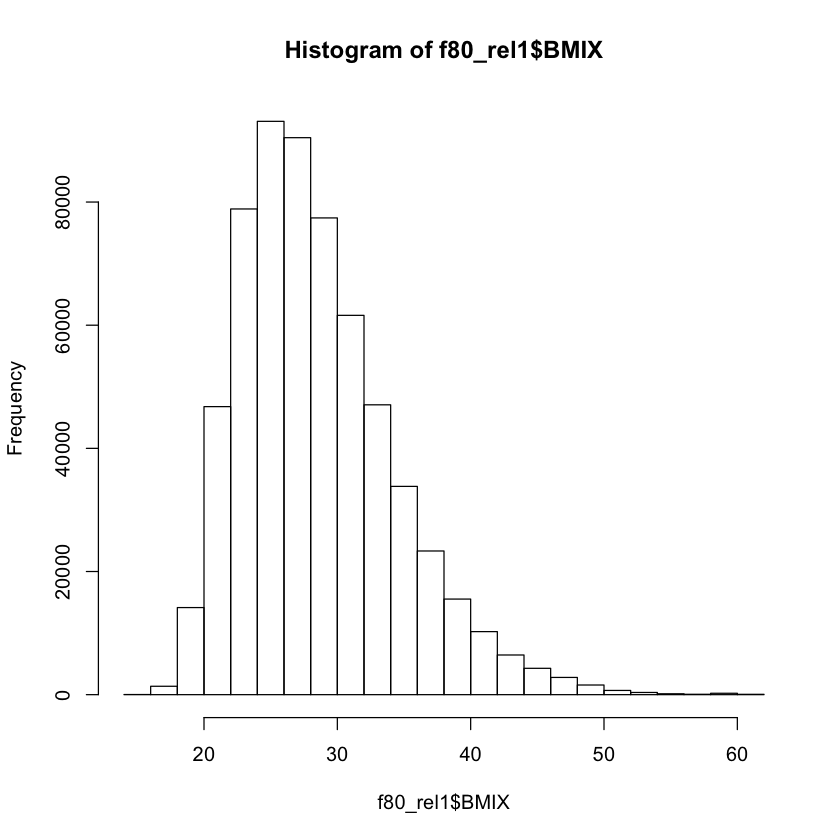

In [55]:
#### x_BMI f80_rel1$BMIX
# x_BMI 	BMI of participant at recruitment derived from f80_rel1$BMIX (numeric)
hist(f80_rel1$BMIX)
phenotypes$x_BMI=f80_rel1[match(phenotypes$studiepersonid, as.character(f80_rel1$SUBJID)),"BMIX"]

In [56]:
#### education_level f20_rel1$EDUC
# education_level Education level of participant (questionnaire)
# 			1	9-year school/Folkskola (f20_rel$EDUC  < 4)
#			2	High School/Gymnasium (f20_rel$EDUC == 4:5)
#			3	University (f20_rel$EDUC > 6)
table(f20_rel1$EDUC)

f20_rel1$education_level=cut(f20_rel1$EDUC, c(0, 3, 6, 20), labels=1:3)
phenotypes$education_level=f20_rel1[match(phenotypes$studiepersonid, as.character(f20_rel1$SUBJID)),"education_level"]


    1     2     3     4     5     6     7     8     9    10    11 
  109   511  1573  5087 23864 14291 39430 15762 16550 21397  3557 

In [57]:
#### smoking_status f34_rel2$SMOKEVR and  f34_rel2$SMOKNOW
# smoking_status	-	smoking status retrieved from corevariables (questionnaire)
#			2	 is current user
#			1 	is previous user
#			0 	is never user
table(f34_rel2$SMOKEVR, f34_rel2$SMOKNOW)


smk_never=f34_rel2[which(f34_rel2$SMOKEVR==0),"SUBJID" ]
smk_prev=f34_rel2[which(f34_rel2$SMOKEVR==1&f34_rel2$SMOKNOW==0),"SUBJID" ]
smk_cur=f34_rel2[which(f34_rel2$SMOKEVR==1&f34_rel2$SMOKNOW==1),"SUBJID" ]

phenotypes[!is.na(match(phenotypes$studiepersonid, smk_never)),"smoking_status"]=0
phenotypes[!is.na(match(phenotypes$studiepersonid, smk_prev)),"smoking_status"]=1
phenotypes[!is.na(match(phenotypes$studiepersonid, smk_cur)),"smoking_status"]=2

   
        0     1
  0     0     0
  1 59714  9821

## ------------ Other Breast Cancer risk factors ---------- ##

In [58]:
# this file contains a list of cancers that are not breast cancer
# computed from column names of outc_ct_os_rel4
# can be copied to text file
cancers=fread("CANCERS_outc_oc_ct_rel4.txt", data.table=FALSE, header=FALSE)
write.table(cancers, row.names=FALSE, quote=FALSE, col.names=FALSE)


SINUS
ADRENAL
ANAL
APPENDIX
BASETONGUE
BILIARY
BLADDER
BONELIMB
BONENON
BRAIN
CNSCA
CERVICAL
COLON
COLORECTAL
CONNECTIVE
ENDOCRINE
ENDMTRL
ESOPHAGUS
EYE
GALLBLDR
GENITAL
GUM
HEART
HYPOPHAR
KIDNEY
LARYNX
LEUKEMIA
LIVER
LUNG
LYMPH
MENINGES
MOUTHFLOOR
NASAL
NASOPHAR
ORALUNSP
OROPHARYNX
OTHERDIGEST
OTHERLIP
OVARY
PALATE
PANCREAS
PAROTID
PERIPHERAL
PERITONEUM
PYRIFORM
RECTOSIG
RECTUM
RENALPELV
RESP
SALIVARY
SMINTEST
STOMACH
THYMUS
THYROID
TONGUE
TONSIL
TRACHEA
URETER
URINARY
UTERINE
VAGINA
VULVA
CANCOTHER
MMYELOMA
MELANOMA
HODGKINS
LYMPHOMA


In [59]:
#### ANYCANCER_BEFORE - number of any type of cancer occured before BC diagnosis
# all different kinds of cancers that were recorded in wHI are stored in cancers (see above)
# compute the number of other cancers (excluding breast cancer) for each individual

#  functions to identify prior and post diagnosis cancer occurence
is_smaller_than_zero=function(number){
    if(is.na(number)){return(NA)}
    # do not count tumors within 1.5 years (540 days) before BC diagnosis
    if(as.numeric(number)+540<=0){return(TRUE)}
    if(as.numeric(number)+540>0 & as.numeric(number)<0){return(NA)}
    if(as.numeric(number)>=0){return(FALSE)}
}


#  add date of diagnosis to outc_ct_os
outc_ct_os$x_diagdate=phenotypes[match(as.character(outc_ct_os$SUBJID), phenotypes$studiepersonid), "x_diagdate"]

# substract diagnosis date of cancers from diagnosis dates of other cancers
tmp_outc=apply(outc_ct_os[, paste(cancers[,1], "DY", sep="")]-outc_ct_os[, "x_diagdate"] , c(1,2), is_smaller_than_zero)

# count the number of all tumors after BC diagnosis
outc_ct_os$ANYCANCER_BEFORE=apply(tmp_outc, 1, sum, na.rm=TRUE)


outc_ct_os$COLONC_BEFORE=tmp_outc[,"COLONDY"]
outc_ct_os$COLORECTALC_BEFORE=tmp_outc[,"COLORECTALDY"]
outc_ct_os$RECTALC_BEFORE=tmp_outc[,"RECTUMDY"]
outc_ct_os$ENDOMETRIALC_BEFORE=tmp_outc[,"ENDMTRLDY"]
outc_ct_os$LUNGC_BEFORE=tmp_outc[,"LUNGDY"]
outc_ct_os$OVARYC_BEFORE=tmp_outc[,"OVARYDY"]
outc_ct_os$MELANOMA_BEFORE=tmp_outc[,"MELANOMADY"]
outc_ct_os$CERVIXC_BEFORE=tmp_outc[,"CERVICALDY"]
outc_ct_os$THYROIDC_BEFORE=tmp_outc[,"THYROIDDY"]
outc_ct_os$BLADDERC_BEFORE=tmp_outc[,"BLADDERDY"]
outc_ct_os$PANCREASC_BEFORE=tmp_outc[,"PANCREASDY"]
outc_ct_os$KIDNEYC_BEFORE=tmp_outc[,"KIDNEYDY"]
outc_ct_os$BRAINC_BEFORE=tmp_outc[,"BRAINDY"]
outc_ct_os$CNSC_BEFORE=tmp_outc[,"CNSCADY"]
outc_ct_os$MENINGES_BEFORE=tmp_outc[,"MENINGESDY"]

outc_ct_os$LYMPHOMA_BEFORE=tmp_outc[,"LYMPHOMADY"]
outc_ct_os$HODGKINS_BEFORE=tmp_outc[,"HODGKINSDY"]
outc_ct_os$MMYELOMA_BEFORE=tmp_outc[,"MMYELOMADY"]
outc_ct_os$LEUKEMIA_BEFORE=tmp_outc[,"LEUKEMIADY"]

#add to phenotypes
phenotypes$ANYCANCER_BEFORE=outc_ct_os[match(phenotypes$studiepersonid, as.character(outc_ct_os$SUBJID)),"ANYCANCER_BEFORE"]


phenotypes$COLORECTALC_BEFORE=0
phenotypes[match(outc_ct_os[which(outc_ct_os$COLONC_BEFORE), "SUBJID"], phenotypes$studiepersonid),"COLORECTALC_BEFORE"]=1
phenotypes[match(outc_ct_os[which(outc_ct_os$COLORECTALC_BEFORE), "SUBJID"], phenotypes$studiepersonid),"COLORECTALC_BEFORE"]=1
phenotypes[match(outc_ct_os[which(outc_ct_os$RECTALC_BEFORE), "SUBJID"], phenotypes$studiepersonid),"COLORECTALC_BEFORE"]=1

phenotypes$ENDOMETRIALC_BEFORE=0
phenotypes[match(outc_ct_os[which(outc_ct_os$ENDOMETRIALC_BEFORE), "SUBJID"], phenotypes$studiepersonid),"ENDOMETRIALC_BEFORE"]=1

phenotypes$LUNGC_BEFORE=0
phenotypes[match(outc_ct_os[which(outc_ct_os$LUNGC_BEFORE), "SUBJID"], phenotypes$studiepersonid),"LUNGC_BEFORE"]=1

phenotypes$OVARYC_BEFORE=0
phenotypes[match(outc_ct_os[which(outc_ct_os$OVARYC_BEFORE), "SUBJID"], phenotypes$studiepersonid),"OVARYC_BEFORE"]=1

# We do not have data on non-melanoma skin cancers in WHI, therefore all patients with melanoma are skin cancer patients
phenotypes$MELANOMA_BEFORE=0
phenotypes[match(outc_ct_os[which(outc_ct_os$MELANOMA_BEFORE), "SUBJID"], phenotypes$studiepersonid),"MELANOMA_BEFORE"]=1
phenotypes$SKINC_BEFORE=phenotypes$MELANOMA_BEFORE
phenotypes$NON_MELANOMA_BEFORE=NA

phenotypes$CERVIXC_BEFORE=0
phenotypes[match(outc_ct_os[which(outc_ct_os$CERVIXC_BEFORE), "SUBJID"], phenotypes$studiepersonid),"CERVIXC_BEFORE"]=1

phenotypes$BLOODC_BEFORE=0
phenotypes[match(outc_ct_os[which(outc_ct_os$LYMPHOMA_BEFORE), "SUBJID"], phenotypes$studiepersonid),"BLOODC_BEFORE"]=1
phenotypes[match(outc_ct_os[which(outc_ct_os$HODGKINS_BEFORE), "SUBJID"], phenotypes$studiepersonid),"BLOODC_BEFORE"]=1
phenotypes[match(outc_ct_os[which(outc_ct_os$MMYELOMA_BEFORE), "SUBJID"], phenotypes$studiepersonid),"BLOODC_BEFORE"]=1
phenotypes[match(outc_ct_os[which(outc_ct_os$LEUKEMIA_BEFORE), "SUBJID"], phenotypes$studiepersonid),"BLOODC_BEFORE"]=1

phenotypes$THYROIDC_BEFORE=0
phenotypes[match(outc_ct_os[which(outc_ct_os$THYROIDC_BEFORE), "SUBJID"], phenotypes$studiepersonid),"THYROIDC_BEFORE"]=1

phenotypes$CNSC_BEFORE=0
phenotypes[match(outc_ct_os[which(outc_ct_os$BRAINC_BEFORE), "SUBJID"], phenotypes$studiepersonid),"CNSC_BEFORE"]=1
phenotypes[match(outc_ct_os[which(outc_ct_os$CNSC_BEFORE), "SUBJID"], phenotypes$studiepersonid),"CNSC_BEFORE"]=1
phenotypes[match(outc_ct_os[which(outc_ct_os$MENINGES_BEFORE), "SUBJID"], phenotypes$studiepersonid),"CNSC_BEFORE"]=1

phenotypes$BLADDERC_BEFORE=0
phenotypes[match(outc_ct_os[which(outc_ct_os$BLADDERC_BEFORE), "SUBJID"], phenotypes$studiepersonid),"BLADDERC_BEFORE"]=1

phenotypes$PANCREASC_BEFORE=0
phenotypes[match(outc_ct_os[which(outc_ct_os$PANCREASC_BEFORE), "SUBJID"], phenotypes$studiepersonid),"PANCREASC_BEFORE"]=1

phenotypes$KIDNEYC_BEFORE=0
phenotypes[match(outc_ct_os[which(outc_ct_os$KIDNEYC_BEFORE), "SUBJID"], phenotypes$studiepersonid),"KIDNEYC_BEFORE"]=1

# exclude blood specific cancers (since thy are not solid tumors)
phenotypes$ANYCANCER_BEFORE=phenotypes$ANYCANCER_BEFORE-phenotypes$BLOODC_BEFORE
table(phenotypes$ANYCANCER_BEFORE)





     0      1      2      3 
142472    254     84      5 

In [60]:
#### ANYCANCER_AFTER - number of any type of cancer occured after BC diagnosis
# all different kinds of cancers that were recorded in wHI are stored in cancers (see above)
# compute the number of other cancers (excluding breast cancer) for each individual


# function to identify post diagnosis cancer occurence
is_greater_than_zero=function(number){
    if(is.na(number)){return(NA)}
    if(number>0){return(TRUE)}
    if(number<=0){return(FALSE)}
}

# add diagnosis date to outc_ct_os
outc_ct_os$x_diagdate=phenotypes[match(as.character(outc_ct_os$SUBJID), phenotypes$studiepersonid), "x_diagdate"]

# substract diagnosis date of cancers from diagnosis dates of other cancers
tmp_outc=apply(outc_ct_os[,paste(cancers[,1], "DY", sep="")]-outc_ct_os[, "x_diagdate"] , c(1,2), is_greater_than_zero)

# count the number of all tumors after BC diagnosis
outc_ct_os$ANYCANCER_AFTER=apply(tmp_outc, 1, sum, na.rm=TRUE)


# and add to outc_ct_os
outc_ct_os$COLONC_AFTER=tmp_outc[,"COLONDY"]
outc_ct_os$COLORECTALC_AFTER=tmp_outc[,"COLORECTALDY"]
outc_ct_os$RECTALC_AFTER=tmp_outc[,"RECTUMDY"]
outc_ct_os$ENDOMETRIALC_AFTER=tmp_outc[,"ENDMTRLDY"]
outc_ct_os$LUNGC_AFTER=tmp_outc[,"LUNGDY"]
outc_ct_os$OVARYC_AFTER=tmp_outc[,"OVARYDY"]
outc_ct_os$MELANOMA_AFTER=tmp_outc[,"MELANOMADY"]
outc_ct_os$CERVIXC_AFTER=tmp_outc[,"CERVICALDY"]
outc_ct_os$THYROIDC_AFTER=tmp_outc[,"THYROIDDY"]
outc_ct_os$BLADDERC_AFTER=tmp_outc[,"BLADDERDY"]
outc_ct_os$PANCREASC_AFTER=tmp_outc[,"PANCREASDY"]
outc_ct_os$KIDNEYC_AFTER=tmp_outc[,"KIDNEYDY"]
outc_ct_os$BRAINC_AFTER=tmp_outc[,"BRAINDY"]
outc_ct_os$CNSC_AFTER=tmp_outc[,"CNSCADY"]
outc_ct_os$MENINGES_AFTER=tmp_outc[,"MENINGESDY"]

outc_ct_os$LYMPHOMA_AFTER=tmp_outc[,"LYMPHOMADY"]
outc_ct_os$HODGKINS_AFTER=tmp_outc[,"HODGKINSDY"]
outc_ct_os$MMYELOMA_AFTER=tmp_outc[,"MMYELOMADY"]
outc_ct_os$LEUKEMIA_AFTER=tmp_outc[,"LEUKEMIADY"]

# add to phenotypes
phenotypes$ANYCANCER_AFTER=outc_ct_os[match(phenotypes$studiepersonid, as.character(outc_ct_os$SUBJID)),"ANYCANCER_AFTER"]


phenotypes$COLORECTALC_AFTER=0
phenotypes[match(outc_ct_os[which(outc_ct_os$COLONC_AFTER), "SUBJID"], phenotypes$studiepersonid),"COLORECTALC_AFTER"]=1
phenotypes[match(outc_ct_os[which(outc_ct_os$COLORECTALC_AFTER), "SUBJID"], phenotypes$studiepersonid),"COLORECTALC_AFTER"]=1
phenotypes[match(outc_ct_os[which(outc_ct_os$RECTALC_AFTER), "SUBJID"], phenotypes$studiepersonid),"COLORECTALC_AFTER"]=1

phenotypes$ENDOMETRIALC_AFTER=0
phenotypes[match(outc_ct_os[which(outc_ct_os$ENDOMETRIALC_AFTER), "SUBJID"], phenotypes$studiepersonid),"ENDOMETRIALC_AFTER"]=1

phenotypes$LUNGC_AFTER=0
phenotypes[match(outc_ct_os[which(outc_ct_os$LUNGC_AFTER), "SUBJID"], phenotypes$studiepersonid),"LUNGC_AFTER"]=1

phenotypes$OVARYC_AFTER=0
phenotypes[match(outc_ct_os[which(outc_ct_os$OVARYC_AFTER), "SUBJID"], phenotypes$studiepersonid),"OVARYC_AFTER"]=1

phenotypes$MELANOMA_AFTER=0
phenotypes[match(outc_ct_os[which(outc_ct_os$MELANOMA_AFTER), "SUBJID"], phenotypes$studiepersonid),"MELANOMA_AFTER"]=1
# We do not have non-melanoma skin cancers in WHI, therefore all patients with melanoma are skin cancer patients
phenotypes$SKINC_AFTER=phenotypes$MELANOMA_AFTER
phenotypes$NON_MELANOMA_AFTER=NA


phenotypes$CERVIXC_AFTER=0
phenotypes[match(outc_ct_os[which(outc_ct_os$CERVIXC_AFTER), "SUBJID"], phenotypes$studiepersonid),"CERVIXC_AFTER"]=1


phenotypes$BLOODC_AFTER=0
phenotypes[match(outc_ct_os[which(outc_ct_os$LYMPHOMA_AFTER), "SUBJID"], phenotypes$studiepersonid),"BLOODC_AFTER"]=1
phenotypes[match(outc_ct_os[which(outc_ct_os$HODGKINS_AFTER), "SUBJID"], phenotypes$studiepersonid),"BLOODC_AFTER"]=1
phenotypes[match(outc_ct_os[which(outc_ct_os$MMYELOMA_AFTER), "SUBJID"], phenotypes$studiepersonid),"BLOODC_AFTER"]=1
phenotypes[match(outc_ct_os[which(outc_ct_os$LEUKEMIA_AFTER), "SUBJID"], phenotypes$studiepersonid),"BLOODC_AFTER"]=1



phenotypes$THYROIDC_AFTER=0
phenotypes[match(outc_ct_os[which(outc_ct_os$THYROIDC_AFTER), "SUBJID"], phenotypes$studiepersonid),"THYROIDC_AFTER"]=1

phenotypes$CNSC_AFTER=0
phenotypes[match(outc_ct_os[which(outc_ct_os$BRAINC_AFTER), "SUBJID"], phenotypes$studiepersonid),"CNSC_AFTER"]=1
phenotypes[match(outc_ct_os[which(outc_ct_os$CNSC_AFTER), "SUBJID"], phenotypes$studiepersonid),"CNSC_AFTER"]=1
phenotypes[match(outc_ct_os[which(outc_ct_os$MENINGES_AFTER), "SUBJID"], phenotypes$studiepersonid),"CNSC_AFTER"]=1

phenotypes$BLADDERC_AFTER=0
phenotypes[match(outc_ct_os[which(outc_ct_os$BLADDERC_AFTER), "SUBJID"], phenotypes$studiepersonid),"BLADDERC_AFTER"]=1

phenotypes$PANCREASC_AFTER=0
phenotypes[match(outc_ct_os[which(outc_ct_os$PANCREASC_AFTER), "SUBJID"], phenotypes$studiepersonid),"PANCREASC_AFTER"]=1

phenotypes$KIDNEYC_AFTER=0
phenotypes[match(outc_ct_os[which(outc_ct_os$KIDNEYC_AFTER), "SUBJID"], phenotypes$studiepersonid),"KIDNEYC_AFTER"]=1



# exclude blood specific cancers (since thy are not solid tumors)
phenotypes$ANYCANCER_AFTER=phenotypes$ANYCANCER_AFTER-phenotypes$BLOODC_AFTER
table(phenotypes$ANYCANCER_AFTER)

,SINUSDY,ADRENALDY,ANALDY,APPENDIXDY,BASETONGUEDY,BILIARYDY,BLADDERDY,BONELIMBDY,BONENONDY,BRAINDY,⋯,URETERDY,URINARYDY,UTERINEDY,VAGINADY,VULVADY,CANCOTHERDY,MMYELOMADY,MELANOMADY,HODGKINSDY,LYMPHOMADY
143208,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
143209,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
143210,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
143211,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
143212,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
143213,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA



     0      1      2      3      4 
141794    802    195     19      5 

In [61]:
#### ANYCANCER - number of any type of cancer other than breast cancer occured AFTER or BEFORE BC diagnosis
phenotypes$ANYCANCER=phenotypes$ANYCANCER_BEFORE+phenotypes$ANYCANCER_AFTER

## -------- Ancestry ---- ##

In [62]:
#### RACE - Racial or ethnic group (questionnair)
#			1=American Indian or Alaskan Native
#			2=Asian or Pacific Islander
#			3=Black or African-American
#			4=Hispanic/Latino
#			5=White (not of Hispanic origin)
#			8=Other  

table(f2_rel1_baseline$RACE)
phenotypes$RACE=f2_rel1_baseline[match(phenotypes$studiepersonid, as.character(f2_rel1_baseline$SUBJID)),"RACE"]
table(phenotypes$RACE)
dim(phenotypes)



     1      2      3      4      5      8 
   614   3498  12151   5468 119539   1595 


     1      2      3      4      5      8 
   613   3492  12114   5456 119200   1592 

[1] 142815     72